## Installation de librairies

In [1]:
pip install unidecode

Note: you may need to restart the kernel to use updated packages.


## Import des librairies

In [2]:
import os
import re
from unidecode import unidecode

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr

from sklearn.preprocessing import  OneHotEncoder

In [3]:
# Obtenir le répertoire actuel
current_directory = os.getcwd()

# Afficher le répertoire actuel
print(f"Répertoire actuel : {current_directory}")

Répertoire actuel : /home/jovyan/MonDossier/UAMO7


## Importation des données

## Chargement et Inspection des Données

- Le fichier d'entraînement (`application_train.csv`) est utilisé pour entraîner le modèle, 
- le fichier de test (`application_test.csv`) représente les données de production, sur lesquelles le modèle sera évalué après son déploiement.

In [4]:
file_train = pd.read_csv("application_train.csv")
file_test = pd.read_csv("application_test.csv")

# Récupérer le nombre de lignes et de colonnes
nb_lignes_train, nb_colonnes_train = file_train.shape

nb_lignes_test, nb_colonnes_test = file_test.shape


# Afficher le résultat
print(f"Le DataFrame train contient : {nb_lignes_train} lignes et {nb_colonnes_train} colonnes.")
# Afficher le résultat
print(f"Le DataFrame test contient:  {nb_lignes_test} lignes et {nb_colonnes_test} colonnes.")

Le DataFrame train contient : 307511 lignes et 122 colonnes.
Le DataFrame test contient:  48744 lignes et 121 colonnes.


# 1. Exploration, Préparation et Analyse des Données

## 1.1 Vérification de la cohérence des données entre Train et Test 

- vérifie que les colonnes et les types de données sont identiques entre les ensembles d’entraînement et de test
- Vérifie que les distributions des variables sont globalement similaires pour detecter un éventuel **covariate shift.**
  - Pour les variables quanti nous avons utiliser test non paramétrique de Mann-Whitney U
  - Pour les variables catégorielles, nous avons comparé les proportions de chaque catégorie entre les deux ensembles.

Ces vérifications assurent une bonne généralisation du modèle et limitent les biais de prédiction.

In [5]:
###############################################################
# Fonction qui compare le nombre de colonnes et les noms des colonnes entre deux DataFrames.
############################################################

def comparer_colonnes(file_train, file_test):
    # Compare le nombre et les noms des colonnes
    train_cols, test_cols = set(file_train.columns), set(file_test.columns)
    print(f"Colonnes file_train : {len(file_train.columns)}, Colonnes file_test : {len(file_test.columns)}")
    
    # Différences de colonnes
    colonnes_diff_train = train_cols - test_cols
    colonnes_diff_test = test_cols - train_cols
    if colonnes_diff_train or colonnes_diff_test:
        print(f"Colonnes différence. file_train: {colonnes_diff_train}, différence. file_test: {colonnes_diff_test}")
    else:
        print("Les deux DataFrames ont les mêmes colonnes.")
    
    # Compter les types de colonnes
    types_train = file_train.dtypes.value_counts().to_dict()
    types_test = file_test.dtypes.value_counts().to_dict()

    # Afficher les types de colonnes
    print("\nTypes de colonnes file_train:", types_train)
    print("Types de colonnes file_test:", types_test)
    
    return types_train, types_test

####################################################################################################
# Fonction qui  Compare les distributions des colonnes numériques (int64 et float64) entre deux DataFrames
# en utilisant le test de Mann-Whitney U.
######################################################################################################

def tester_distributions_quanti(file_train, file_test):
    types_train, types_test = comparer_colonnes(file_train, file_test)

    # Résultats des tests
    results = {'int64': {'différents': [], 'similaires': []}, 
               'float64': {'différents': [], 'similaires': []}}

    for dtype in ['int64', 'float64']:
        for col in file_train.select_dtypes(include=[dtype]).columns:
            if col in file_test.columns:
                stat, p_value = mannwhitneyu(file_train[col], file_test[col], alternative='two-sided')
                results[dtype]['différents' if p_value < 0.05 else 'similaires'].append(col)

    # Ajouter le nombre de variables similaires/différentes
    for dtype in results:
        results[dtype]['nombre_similaires'] = len(results[dtype]['similaires'])
        results[dtype]['nombre_différents'] = len(results[dtype]['différents'])
    
    return results

############################################################################
#  Affiche les distributions des colonnes avec des différences dans les distributions.
###########################################################################

def plot_differences_quanti(file_train, file_test, results, dtype='int64'):
    # Récupérer les colonnes avec des distributions différentes pour le type spécifié
    different_cols = results[dtype]['différents'][:10]
    
    if not different_cols:
        print(f"Aucune colonne de type '{dtype}' avec des distributions différentes.")
        return
    
    # Créer une figure pour les visualisations
    plt.figure(figsize=(15, 10))
    
    # Affichage des histogrammes pour les colonnes sélectionnées
    for i, col in enumerate(different_cols):
        plt.subplot(4, 3, i + 1)  # Placer les graphiques dans une grille 4x3
        plt.hist(file_train[col], bins=30, alpha=0.5, label='Train', color='blue')
        plt.hist(file_test[col], bins=30, alpha=0.5, label='Test', color='orange')
        plt.title(f"Distribution de {col}")
        plt.xlabel('Valeurs')
        plt.ylabel('Fréquence')
        plt.legend()
    
    plt.tight_layout()
    plt.show()




In [6]:
def comparer_distributions_quali(file_train, file_test, tolerance=0.05):
    results = {'similaires': [], 'différents': []}

    # Compare les distributions des colonnes qualitatives
    for col in file_train.select_dtypes(include=['object']).columns:
        if col in file_test.columns:
            # Calcul des distributions normalisées
            train_dist = file_train[col].value_counts(normalize=True).sort_index()
            test_dist = file_test[col].value_counts(normalize=True).sort_index()

            # Union des index et réindexation
            combined_index = train_dist.index.union(test_dist.index)
            train_dist, test_dist = train_dist.reindex(combined_index, fill_value=0), test_dist.reindex(combined_index, fill_value=0)

            # Vérifier la différence avec tolérance
            if (abs(train_dist - test_dist) <= tolerance).all():
                results['similaires'].append(col)
            else:
                results['différents'].append(col)

    # Résumé des résultats
    print(f"\nColonnes similaires : {len(results['similaires'])}, Colonnes différentes : {len(results['différents'])}")
    print("Colonnes différentes :", results['différents'])

    # Visualisation pour les colonnes différentes
    for col in results['différents']:
        print(f"Visualisation de la distribution pour {col}")
        df_counts = pd.DataFrame({'Train': train_dist, 'Test': test_dist}).reset_index()
        df_counts.columns = [col, 'Train', 'Test']
        df_counts.plot(x=col, kind='bar', stacked=False, figsize=(10, 6))
        plt.title(f"Distribution de {col} dans les ensembles d'entraînement et de test")
        plt.ylabel("Proportion")
        plt.xlabel(col)
        plt.xticks(rotation=45)
        plt.legend(title='Ensemble', labels=['Entraînement', 'Test'])
        plt.tight_layout()
        plt.show()

    return results


**Appel de la fonction comparer_colonnes(file_train, file_test)**

In [7]:
results = tester_distributions_quanti(file_train, file_test)

Colonnes file_train : 122, Colonnes file_test : 121
Colonnes différence. file_train: {'TARGET'}, différence. file_test: set()

Types de colonnes file_train: {dtype('float64'): 65, dtype('int64'): 41, dtype('O'): 16}
Types de colonnes file_test: {dtype('float64'): 65, dtype('int64'): 40, dtype('O'): 16}


**Appel de la fonction qui Compare les distributions des colonnes numériques**

In [8]:
# Affichage des résultats pour int64
print("\nRésultats pour les colonnes de type 'int64' :")
print(f"Nombre de colonnes similaires : {results['int64']['nombre_similaires']}")
print(f"Nombre de colonnes différentes : {results['int64']['nombre_différents']}")
# print("Colonnes similaires :", results['int64']['similaires'])
print("Colonnes différentes :", results['int64']['différents'])

# Affichage des résultats pour float64
print("\nRésultats pour les colonnes de type 'float64' :")
print(f"Nombre de colonnes similaires : {results['float64']['nombre_similaires']}")
print(f"Nombre de colonnes différentes : {results['float64']['nombre_différents']}")
# print("Colonnes similaires :", results['float64']['similaires'])
print("Colonnes différentes :", results['float64']['différents'])


Résultats pour les colonnes de type 'int64' :
Nombre de colonnes similaires : 13
Nombre de colonnes différentes : 27
Colonnes différentes : ['CNT_CHILDREN', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

Résultats pour les colonnes de type 'float64' :
Nombre de colonnes similaires : 63
Nombre de colonnes différentes : 2
Colonnes différentes : ['AMT_INCOME_TOTAL', 'AMT_CREDIT']


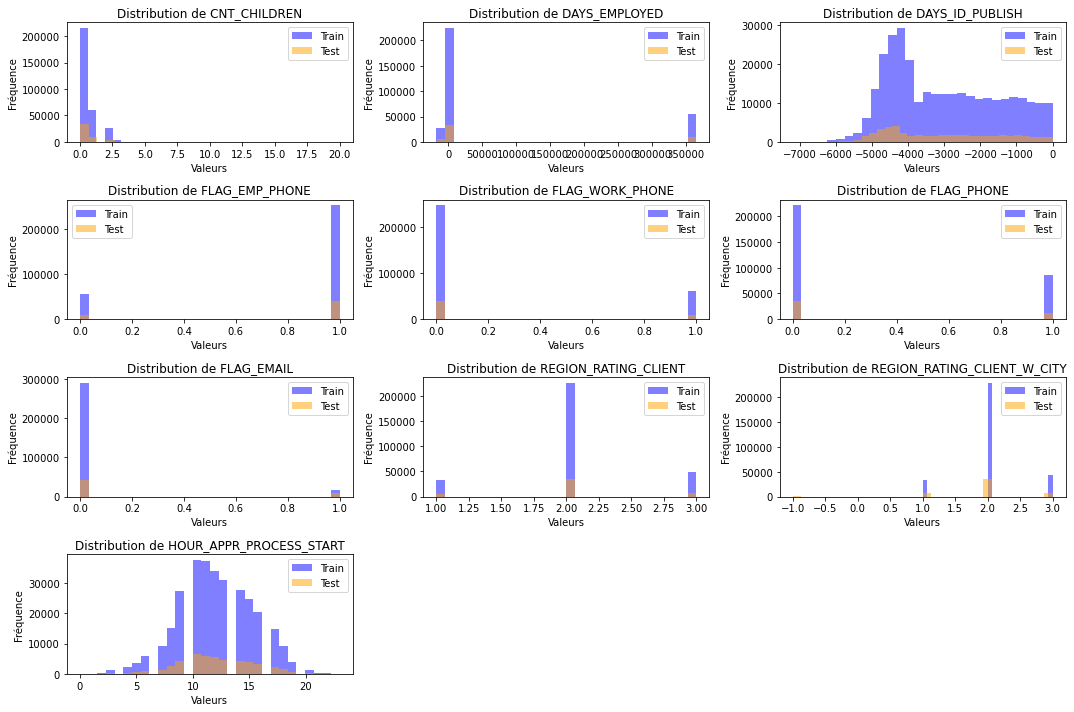

In [9]:
# Appeler la fonction pour tracer les différences
plot_differences_quanti(file_train, file_test, results, dtype='int64')

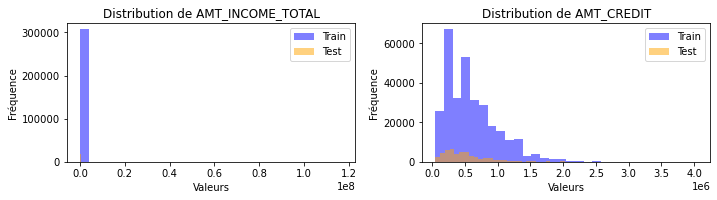

In [10]:
# Appeler la fonction pour tracer les différences
plot_differences_quanti(file_train, file_test, results, dtype='float64')

**Appel de la fonction qui Compare les distributions des colonnes qualitatives**


Colonnes similaires : 15, Colonnes différentes : 1
Colonnes différentes : ['NAME_CONTRACT_TYPE']
Visualisation de la distribution pour NAME_CONTRACT_TYPE


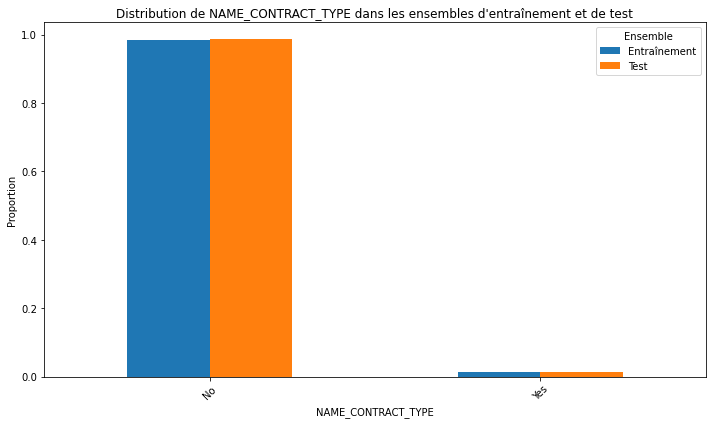

In [11]:
results_quali = comparer_distributions_quali(file_train, file_test)


**On constate :** 
Après vérification, les colonnes et les types de données sont identiques dans les deux ensembles. L'analyse statistique a révélé quelques différences significatives, mais les distributions restent globalement similaires. Les tests statistiques peuvent être sensibles aux petites variations, particulièrement avec de grands échantillons.

## 1.2 Nettoyage et traitement des données

Assurer la qualité des données en traitant les anomalies dans les ensembles d’entraînement et de test, tout en préservant l'intégrité du modèle.

Cette étape permet également de réduire les risques de data leakage en s’assurant que :
- Les données de test restent indépendantes des données d’entraînement.
- Aucune information future ou liée aux labels ne contamine le processus d'entraînement

### 1.2.1 Vérification des doublons

Ces fonctions visent à :

- Identifier et analyser les lignes dupliquées dans le dataset, ainsi que les doublons éventuels dans la variable clé SK_ID_CURR.
- Vérifier s'il existe un chevauchement des identifiants SK_ID_CURR entre les jeux d'entraînement et de test, ce qui pourrait introduire des biais dans l'évaluation du modèle.


In [12]:
#################################################################################
# On verifie sur l'ensemble des lignes du data et sur la variable clé SK_ID_CURR
############################################################################

def doublons(data):
    
    # 1. Sur l'ensemble du data
    
    # Compter le nombre de doublons
    num_duplicates = data.duplicated().sum()
    print(f"Nombre de lignes dupliquées : {num_duplicates}")

    # Si des doublons existent, afficher les lignes dupliquées
    if num_duplicates > 0:
        # Filtrer les doublons et les afficher
        duplicated_rows = data[data.duplicated(keep=False)]  # keep=False pour garder toutes les occurrences
        print("\nLignes dupliquées :")
        print(duplicated_rows)
    else:
        print("Aucune ligne dupliquée trouvée.")
        print()

    # 2. Sur la variable clé SK_ID_CURR
    if 'SK_ID_CURR' in data.columns:
        # Vérifier les doublons dans la colonne SK_ID_CURR
        duplicates = data[data['SK_ID_CURR'].duplicated(keep=False)]

        # Afficher les doublons
        if duplicates.empty:
            print("Tous les identifiants SK_ID_CURR sont uniques dans le DataFrame.")
        else:
            print(f"Il y a {duplicates.shape[0]} doublons trouvés dans SK_ID_CURR.")
            print("Identifiants en double :")
            print(duplicates[['SK_ID_CURR']].drop_duplicates())  # Afficher les identifiants en double
    else:
        print("La colonne 'SK_ID_CURR' n'existe pas dans le DataFrame.")
        

        
#######################################################################################################################        
# On Vérifie si il y'a un chevauchement des identifiants SK_ID_CURR entre les jeux de données d'entraînement et de test.
#######################################################################################################################

def check_id_overlap(train_data, test_data):
   
    # Vérifie si 'SK_ID_CURR' existe dans les deux DataFrames
    if 'SK_ID_CURR' not in train_data.columns or 'SK_ID_CURR' not in test_data.columns:
        print("Erreur : La colonne 'SK_ID_CURR' doit être présente dans les deux DataFrames.")
        return

    # Compare les valeurs uniques
    train_ids = set(train_data['SK_ID_CURR'])
    test_ids = set(test_data['SK_ID_CURR'])

    # Trouve les identifiants communs
    common_ids = train_ids.intersection(test_ids)

    # Affiche les résultats
    if not common_ids:
        print("Il n'y a pas de chevauchement de SK_ID_CURR entre train et test.")
    else:
        print(f"Il y a un chevauchement des SK_ID_CURR suivants entre train et test : {common_ids}")


In [13]:
# Appel de la fonction pour voir les doublons du train
print("Train :")
doublons(file_train)
print("\n")

##### Appel de la fonction pour voir les doublons du test
print("Test :")
doublons(file_test)
print("\n")

# Appel de la fonction pour voir les doublons entre le train et le test en fonction de SK_ID_CURR
print("Chevauchement entre train et test (SK_ID_CURR) :")
check_id_overlap(file_train, file_test)


Train :
Nombre de lignes dupliquées : 0
Aucune ligne dupliquée trouvée.

Tous les identifiants SK_ID_CURR sont uniques dans le DataFrame.


Test :
Nombre de lignes dupliquées : 0
Aucune ligne dupliquée trouvée.

Tous les identifiants SK_ID_CURR sont uniques dans le DataFrame.


Chevauchement entre train et test (SK_ID_CURR) :
Il n'y a pas de chevauchement de SK_ID_CURR entre train et test.


### 1.2.2 Gestion des valeurs aberrantes / atypiques 

#### Vérification pour les types int64

In [14]:
# Identification et comptage des valeurs uniques dans les colonnes de type entier

int_cols = file_train.select_dtypes(include=['int64']).columns
print("nombre de col :" ,len(int_cols))
print()

# Affiche le nombre de valeurs uniques dans chaque colonne entière
print(file_train[int_cols].nunique())

nombre de col : 41

SK_ID_CURR                     307511
TARGET                              2
CNT_CHILDREN                       15
DAYS_BIRTH                      17460
DAYS_EMPLOYED                   12574
DAYS_ID_PUBLISH                  6168
FLAG_MOBIL                          2
FLAG_EMP_PHONE                      2
FLAG_WORK_PHONE                     2
FLAG_CONT_MOBILE                    2
FLAG_PHONE                          2
FLAG_EMAIL                          2
REGION_RATING_CLIENT                3
REGION_RATING_CLIENT_W_CITY         3
HOUR_APPR_PROCESS_START            24
REG_REGION_NOT_LIVE_REGION          2
REG_REGION_NOT_WORK_REGION          2
LIVE_REGION_NOT_WORK_REGION         2
REG_CITY_NOT_LIVE_CITY              2
REG_CITY_NOT_WORK_CITY              2
LIVE_CITY_NOT_WORK_CITY             2
FLAG_DOCUMENT_2                     2
FLAG_DOCUMENT_3                     2
FLAG_DOCUMENT_4                     2
FLAG_DOCUMENT_5                     2
FLAG_DOCUMENT_6               

In [15]:
### voir les variables dates à quoi ressemble
file_train[['DAYS_BIRTH', 'DAYS_EMPLOYED','DAYS_ID_PUBLISH', 'HOUR_APPR_PROCESS_START']].head()

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,HOUR_APPR_PROCESS_START
0,-9461,-637,-2120,10
1,-16765,-1188,-291,11
2,-19046,-225,-2531,9
3,-19005,-3039,-2437,17
4,-19932,-3038,-3458,11


On constate que :

- DAYS_BIRTH : Âge de la personne en jours (valeurs négatives indiquant le nombre de jours avant la date actuelle).
- DAYS_EMPLOYED : Durée de l'emploi en jours (valeurs négatives, indiquant le nombre de jours depuis le début de l'emploi).
- DAYS_ID_PUBLISH : Nombre de jours depuis la publication de l'identifiant de la personne (valeurs négatives).
- HOUR_APPR_PROCESS_START : Heure (sur une échelle de 24 heures) à laquelle le processus de demande d'approbation a commencé.

Pour une meilleurs comprehension on convertir les colonnes DAYS_BIRTH, DAYS_EMPLOYED et DAYS_ID_PUBLISH en années

In [16]:
def changement_days_years(df):
   
    # Convertir les jours en années
    df['AGE'] = (df['DAYS_BIRTH'] / -365.25).astype(int)  # Âge en années
    df['EMPLOYMENT_DURATION'] = (df['DAYS_EMPLOYED'] / -365.25).astype(int)  # Durée d'emploi en années
    df['PUBLISH_DURATION'] = (df['DAYS_ID_PUBLISH'] / -365.25).astype(int)  # Durée depuis la publication en années
    
    # Supprime les anciennes colonnes
    df = df.drop(columns=['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH'])
    
    return df


train = changement_days_years(file_train)
test = changement_days_years(file_test)

**Nous allons nous interesser aux variables qui ont plus de deux valeurs uniques**

In [17]:
int_cols = train.select_dtypes(include=['int64']).columns

# Compte le nombre de valeurs uniques pour chaque colonne de type int64
unique_counts = train[int_cols].nunique()

# Filtre pour trouver les colonnes avec plus de deux valeurs uniques
plus_columns = unique_counts[unique_counts > 2].index  # Utilisation de .index pour récupérer les noms des colonnes


train[plus_columns].head()

,SK_ID_CURR,CNT_CHILDREN,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,AGE,EMPLOYMENT_DURATION,PUBLISH_DURATION
0,100002,0,2,2,10,25,1,5
1,100003,0,1,1,11,45,3,0
2,100004,0,2,2,9,52,0,6
3,100006,0,2,2,17,52,8,6
4,100007,0,2,2,11,54,8,9


In [18]:
# On affiche les statistiques descriptives arrondies pour les colonnes sélectionnées
print(round(train[plus_columns].describe(), 3))

       SK_ID_CURR  CNT_CHILDREN  REGION_RATING_CLIENT  \
count  307511.000    307511.000            307511.000   
mean   278180.519         0.417                 2.052   
std    102790.175         0.722                 0.509   
min    100002.000         0.000                 1.000   
25%    189145.500         0.000                 2.000   
50%    278202.000         0.000                 2.000   
75%    367142.500         1.000                 2.000   
max    456255.000        19.000                 3.000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START         AGE  \
count                   307511.000               307511.000  307511.000   
mean                         2.032                   12.063      43.405   
std                          0.503                    3.266      11.946   
min                          1.000                    0.000      20.000   
25%                          2.000                   10.000      33.000   
50%                          2.000  

A partir de ces statistiques descriptives nous allons parler des variables qui presente des resultats comme potentiellement **atypiques** ou **aberrantes** :

1. **CNT_CHILDREN (Nombre d'enfants)** :
   - La plupart des individus ont peu ou pas d’enfants, comme le montre la médiane (50e percentile) à 0 et le 75e percentile à 1.
   - Le maximum est de **19 enfants**, ce qui est très élevé et peut représenter des valeurs erronées ou des cas rares. 
   
2. **EMPLOYMENT_DURATION (Durée d’emploi)** :
   - La moyenne de **-174.946** et la valeur minimale de **-999** suggèrent des erreurs ou des valeurs codées pour indiquer des données manquantes. D'ailleurs -999 sont couramment utilisées comme code pour représenter une valeur manquante et doivent être remplacées par `NaN`.
 



**Vérification des outliers**

In [19]:
# Compter le nombre de lignes pour chaque valeur unique dans 'CNT_CHILDREN'
print(train['CNT_CHILDREN'].value_counts())

0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
8          2
9          2
12         2
10         2
19         2
11         1
Name: CNT_CHILDREN, dtype: int64


In [20]:
# Filtrer les valeurs négatives dans 'EMPLOYMENT_DURATION'
negative_values = file_train[file_train['EMPLOYMENT_DURATION'] < 0]['EMPLOYMENT_DURATION']

# Compter le nombre de lignes avec des valeurs négatives
count_negative_values = negative_values.shape[0]

# Obtenir les valeurs uniques parmi les valeurs négatives
unique_negative_values = negative_values.unique()

# Compter le nombre de valeurs uniques
count_unique_negative_values = len(unique_negative_values)

# Affichage des résultats
print(f"Nombre de lignes avec des valeurs négatives dans 'EMPLOYMENT_DURATION' : {count_negative_values}")
print(f"Nombre de valeurs uniques négatives dans 'EMPLOYMENT_DURATION' : {count_unique_negative_values}")
print("\nValeurs uniques négatives :")
print(unique_negative_values)

Nombre de lignes avec des valeurs négatives dans 'EMPLOYMENT_DURATION' : 55374
Nombre de valeurs uniques négatives dans 'EMPLOYMENT_DURATION' : 1

Valeurs uniques négatives :
[-999]


#### Modification des variables int64 se portera

- **CNT_CHILDREN**: Suppression des lignes où le nombre d'enfants est supérieur à 10.
- **EMPLOYMENT_DURATION :** Remplacement des valeurs -999  par NaN.

In [21]:
def modification_var_int64(data):
    # Créer une copie pour éviter SettingWithCopyWarning
    data = data[data['CNT_CHILDREN'] <= 10].copy() 
    
    # Regrouper les valeurs 7, 8, 9, et 10 dans CNT_CHILDREN et les remplacer par '7+'
    data['CNT_CHILDREN'] = data['CNT_CHILDREN'].replace({5:'5_plus', 6:'5_plus', 7:'5_plus',
                                                         8:'5_plus', 9:'5_plus', 10:'5_plus'}).astype(str)
    
    # Remplacer -999 par NaN dans EMPLOYMENT_DURATION
    data['EMPLOYMENT_DURATION'] = data['EMPLOYMENT_DURATION'].replace({-999: np.nan})
    
    return data


In [22]:
##### Appel de la fonction pour modfication

modified_train_int64 = modification_var_int64(train)
modified_test_int64 = modification_var_int64(test)

In [23]:
# Vérification des modifications dans le DataFrame d'entraînement
print("Vérifications pour le DataFrame train :")
print("Nombre de lignes avant modification : ", train.shape[0])
print("Nombre de lignes après modification : ", modified_train_int64.shape[0])

# Vérifier les valeurs NaN dans EMPLOYMENT_DURATION
nan_count = modified_train_int64['EMPLOYMENT_DURATION'].isna().sum()
print("Nombre de valeurs NaN dans 'EMPLOYMENT_DURATION' : ", nan_count)

# Vérification des valeurs uniques de CNT_CHILDREN
unique_children = modified_train_int64['CNT_CHILDREN'].unique()
print("Valeurs uniques dans 'CNT_CHILDREN' : ", unique_children)

# Vérification des modifications dans le DataFrame de test
print("\nVérifications pour le DataFrame test :")
print("Nombre de lignes avant modification : ", test.shape[0])
print("Nombre de lignes après modification : ", modified_test_int64.shape[0])

# Vérifier les valeurs NaN dans EMPLOYMENT_DURATION
nan_count_test = modified_test_int64['EMPLOYMENT_DURATION'].isna().sum()
print("Nombre de valeurs NaN dans 'EMPLOYMENT_DURATION' (test) : ", nan_count_test)

# Vérification des valeurs uniques de CNT_CHILDREN
unique_children_test = modified_test_int64['CNT_CHILDREN'].unique()
print("Valeurs uniques dans 'CNT_CHILDREN' (test) : ", unique_children_test)


Vérifications pour le DataFrame train :
Nombre de lignes avant modification :  307511
Nombre de lignes après modification :  307503
Nombre de valeurs NaN dans 'EMPLOYMENT_DURATION' :  55373
Valeurs uniques dans 'CNT_CHILDREN' :  ['0' '1' '2' '3' '4' '5_plus']

Vérifications pour le DataFrame test :
Nombre de lignes avant modification :  48744
Nombre de lignes après modification :  48741
Nombre de valeurs NaN dans 'EMPLOYMENT_DURATION' (test) :  9274
Valeurs uniques dans 'CNT_CHILDREN' (test) :  ['0' '2' '1' '3' '5_plus' '4']


#### Vérification pour les types float64

In [24]:
float_cols = modified_train_int64.select_dtypes(include=['float64']).columns
print( "nbre de varaibles:" ,len(float_cols) )


# Vérifier si des valeurs infinies existent dans les colonnes float
if any(np.isinf(modified_train_int64[float_cols]).sum()):
    print("Certaines colonnes contiennent des valeurs infinies.")
else:
    print("Aucune des colonnes float64 ne contient de valeurs infinies.")

nbre de varaibles: 66
Aucune des colonnes float64 ne contient de valeurs infinies.


In [25]:
## On vérifie si y' a des valeurs négatives concernant le temps

for col in float_cols:
    negatives = modified_train_int64[modified_train_int64[col] < 0]
    if not negatives.empty:
        print(f"{col} contient {len(negatives)} valeurs négatives")

DAYS_REGISTRATION contient 307423 valeurs négatives
DAYS_LAST_PHONE_CHANGE contient 269830 valeurs négatives


In [26]:
def convert_days_to_years(df, columns_to_convert):
   
    for col in columns_to_convert:
        # Nouveau nom pour la colonne en années
        new_col_name = f"{col}_YEARS"
        
        # Conversion des jours en années en gérant les valeurs manquantes
        df[new_col_name] = abs(df[col]) / 365.25
        
        # Arrondir et convertir en entier tout en préservant les NaN
        df[new_col_name] = df[new_col_name].round()
        df[new_col_name] = df[new_col_name].astype('Int64')  # Type entier qui accepte NaN
    
    # Supprimer les colonnes originales
    df.drop(columns=columns_to_convert, inplace=True)
    
    return df


In [27]:
## Appel de la fonction

# Colonnes à convertir
columns_to_convert = ['DAYS_REGISTRATION', 'DAYS_LAST_PHONE_CHANGE']

# Appliquer la fonction pour le DataFrame de train
modified_train_int64 = convert_days_to_years(modified_train_int64, columns_to_convert)

# Appliquer la fonction pour le DataFrame de test
modified_test_int64 = convert_days_to_years(modified_test_int64, columns_to_convert)

In [28]:
## Vérification
print(modified_train_int64.shape)
print(modified_test_int64.shape)

(307503, 122)
(48741, 121)


**Nous jetons un coup d'oeil rapides avec des stats descriptives sur les variables dates**

In [29]:
stats_in_years = modified_train_int64[['DAYS_REGISTRATION_YEARS', 'DAYS_LAST_PHONE_CHANGE_YEARS']].describe()

# Afficher les statistiques
print(round(stats_in_years),2)

       DAYS_REGISTRATION_YEARS  DAYS_LAST_PHONE_CHANGE_YEARS
count                 307503.0                      307502.0
mean                      14.0                           3.0
std                       10.0                           2.0
min                        0.0                           0.0
25%                        6.0                           1.0
50%                       12.0                           2.0
75%                       20.0                           4.0
max                       68.0                          12.0 2


**On constate :**

- La durée d'enregistrement d'un client `(DAYS_REGISTRATION_YEARS)` est en moyenne de 14 ans, avec une médiane de 12 ans. Cependant, certaines données indiquent des enregistrements récents (0 ans) ou très anciens (jusqu'à 68 ans), ces derniers pouvant être rares ou suspects.
- Le temps écoulé depuis le dernier changement de téléphone `(DAYS_LAST_PHONE_CHANGE_YEARS)` est en moyenne de 3 ans (médiane : 2 ans), avec des valeurs allant de 0 (changement très récent) à 12 ans, ce qui peut représenteréventuellement des cas inhabituels.


**Pour traiter les anomalies identifiées dans les données, nous avons créé une fonction qui :**

- Identifie les enregistrements suspects, tels que ceux avec une durée d'enregistrement très longue (> 55 ans), des enregistrements incohérents (avant la naissance ou moins de 17 ans après), ou égaux à l'âge du client.
- Supprime ces enregistrements pour garantir des données cohérentes et fiables.

In [30]:
def clean_and_report_data(df):
  
    # Taille avant suppression
    initial_size = df.shape[0]
    print(f"Taille du DataFrame avant suppression : {initial_size}")
    
    # Filtrer les différents groupes d'enregistrements
    old_registrations = df[df['DAYS_REGISTRATION_YEARS'] > 55]
    registrations_near_birth = df[(df['AGE'] - df['DAYS_REGISTRATION_YEARS']) < 17]
    reg_before_birth = df[df['DAYS_REGISTRATION_YEARS'] < 0]
    age_to_regist = df[df['DAYS_REGISTRATION_YEARS'] == df['AGE']]
    
    # Afficher les statistiques
    print("Nombre d'enregistrements de plus de 55 ans :", len(old_registrations))
    print("Nombre d'enregistrements faits moins de 17 ans après la naissance :", len(registrations_near_birth))
    print("Nombre de personne enregistrée avant sa naissance :", len(reg_before_birth))
    print("Nombre de personne enregistrée ayant le même âge :", len(age_to_regist))

    # Obtenir les indices des enregistrements à supprimer
    indices_to_remove = set(old_registrations.index) \
        .union(set(registrations_near_birth.index)) \
        .union(set(reg_before_birth.index)) \
        .union(set(age_to_regist.index))
    
    # Supprimer les indices du DataFrame
    cleaned_df = df.drop(index=indices_to_remove, errors='ignore')
    
    # Afficher le nombre total de lignes supprimées et la taille après suppression
    print(f"Nombre total de lignes supprimées : {len(indices_to_remove)}")
    print(f"Taille du DataFrame après suppression : {cleaned_df.shape[0]}")
    
    return cleaned_df


In [31]:
## Appel de la fonction
print("Train :")
modified_train_int_float= clean_and_report_data(modified_train_int64)

print("\nTest :")
modified_test_int_float= clean_and_report_data(modified_test_int64)

Train :
Taille du DataFrame avant suppression : 307503
Nombre d'enregistrements de plus de 55 ans : 28
Nombre d'enregistrements faits moins de 17 ans après la naissance : 47917
Nombre de personne enregistrée avant sa naissance : 0
Nombre de personne enregistrée ayant le même âge : 2895
Nombre total de lignes supprimées : 47917
Taille du DataFrame après suppression : 259586

Test :
Taille du DataFrame avant suppression : 48741
Nombre d'enregistrements de plus de 55 ans : 3
Nombre d'enregistrements faits moins de 17 ans après la naissance : 7727
Nombre de personne enregistrée avant sa naissance : 0
Nombre de personne enregistrée ayant le même âge : 442
Nombre total de lignes supprimées : 7727
Taille du DataFrame après suppression : 41014


#### Détection des valeurs aberrantes et extrêmes pour les autres variables

1. **Valeurs aberrantes avec l'IQR** :
   - L'IQR (Interquartile Range) est la différence entre le 75ᵉ (Q3) et le 25ᵉ (Q1) centile.
   - Seuils de détection : 
     - **Inférieur** : \( Q1 - 1.5 \times IQR \)
     - **Supérieur** : \( Q3 + 1.5 \times IQR \)
   - Les valeurs en dehors de ces limites sont considérées comme **aberrantes**.

2. **Identification des valeurs extrêmes** :
   - Les valeurs supérieures au **95ᵉ centile** sont considérées comme **extrêmes**.

3. **Proportion d'anomalies** :
   - Si plus de **5 %** des valeurs d'une colonne sont aberrantes ou extrêmes, un message est affiché pour identifier les variables nécessitant une analyse ou un traitement spécifique.


In [32]:
# On selectionne uniquement les types float64
float_cols = modified_train_int_float.select_dtypes(include=['float64']).columns

# Nombre total de lignes dans le DataFrame
total_rows = len(modified_train_int_float)

# Seuil pour 5 % des lignes
threshold_5_percent = total_rows * 0.05

# Détection des valeurs aberrantes et extrêmes avec IQR
for col in float_cols:
    # Calcul de l'IQR
    Q1 = modified_train_int_float[col].quantile(0.25)
    Q3 = modified_train_int_float[col].quantile(0.75)
    IQR = Q3 - Q1

    # Définir les seuils pour les valeurs aberrantes
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Détection des valeurs aberrantes
    outlier_mask = (modified_train_int_float[col] < lower_bound) | (modified_train_int_float[col] > upper_bound)
    num_outliers = outlier_mask.sum()

    # Détection des valeurs extrêmes
    high_threshold = modified_train_int_float[col].quantile(0.95)
    extreme_values = modified_train_int_float[modified_train_int_float[col] > high_threshold]
    num_extreme_values = len(extreme_values)

    # Vérifier si le nombre de valeurs aberrantes dépasse 5 %
    if num_outliers > threshold_5_percent:
        print(f"{col} contient {num_outliers} valeurs aberrantes selon l'IQR, ce qui représente plus de 5 % des données.")

    # Vérifier si le nombre de valeurs extrêmes dépasse 5 %
    if num_extreme_values > threshold_5_percent:
        print(f"{col} contient {num_extreme_values} valeurs extrêmes, ce qui représente plus de 5 % des données.")

# Message si aucune colonne n'a plus de 5 % de valeurs aberrantes ou extrêmes
if all(((modified_train_int_float[col] < (modified_train_int_float[col].quantile(0.25) - 1.5 * (modified_train_int_float[col].quantile(0.75) - modified_train_int_float[col].quantile(0.25)))).sum() + 
        (modified_train_int_float[col] > (modified_train_int_float[col].quantile(0.75) + 1.5 * (modified_train_int_float[col].quantile(0.75) - modified_train_int_float[col].quantile(0.25)))).sum()) <= threshold_5_percent for col in float_cols) and \
       all(len(modified_train_int_float[modified_train_int_float[col] > modified_train_int_float[col].quantile(0.95)]) <= threshold_5_percent for col in float_cols):
    print("Aucune des variables n'a plus de 5 % de valeurs aberrantes ou extrêmes.")


NONLIVINGAREA_AVG contient 13462 valeurs aberrantes selon l'IQR, ce qui représente plus de 5 % des données.
NONLIVINGAREA_MODE contient 15341 valeurs aberrantes selon l'IQR, ce qui représente plus de 5 % des données.
NONLIVINGAREA_MEDI contient 13986 valeurs aberrantes selon l'IQR, ce qui représente plus de 5 % des données.
OBS_30_CNT_SOCIAL_CIRCLE contient 17007 valeurs aberrantes selon l'IQR, ce qui représente plus de 5 % des données.
DEF_30_CNT_SOCIAL_CIRCLE contient 29689 valeurs aberrantes selon l'IQR, ce qui représente plus de 5 % des données.
OBS_60_CNT_SOCIAL_CIRCLE contient 16672 valeurs aberrantes selon l'IQR, ce qui représente plus de 5 % des données.
DEF_60_CNT_SOCIAL_CIRCLE contient 21683 valeurs aberrantes selon l'IQR, ce qui représente plus de 5 % des données.
AMT_REQ_CREDIT_BUREAU_MON contient 36894 valeurs aberrantes selon l'IQR, ce qui représente plus de 5 % des données.
AMT_REQ_CREDIT_BUREAU_QRT contient 43177 valeurs aberrantes selon l'IQR, ce qui représente plus de

**On jette un coup d'oeil rapide**

In [33]:
columns_with_outliers = [
    'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MODE', 'NONLIVINGAREA_MEDI',
    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
    'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT'
]

# Statistiques descriptives
print(modified_train_int_float[columns_with_outliers].describe())


       NONLIVINGAREA_AVG  NONLIVINGAREA_MODE  NONLIVINGAREA_MEDI  \
count      113331.000000       113331.000000       113331.000000   
mean            0.028912            0.027613            0.028820   
std             0.071104            0.071714            0.071714   
min             0.000000            0.000000            0.000000   
25%             0.000000            0.000000            0.000000   
50%             0.003600            0.001200            0.003200   
75%             0.028300            0.023700            0.027300   
max             1.000000            1.000000            1.000000   

       OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
count             258785.000000             258785.000000   
mean                   1.426470                  0.143625   
std                    2.421654                  0.448029   
min                    0.000000                  0.000000   
25%                    0.000000                  0.000000   
50%                  

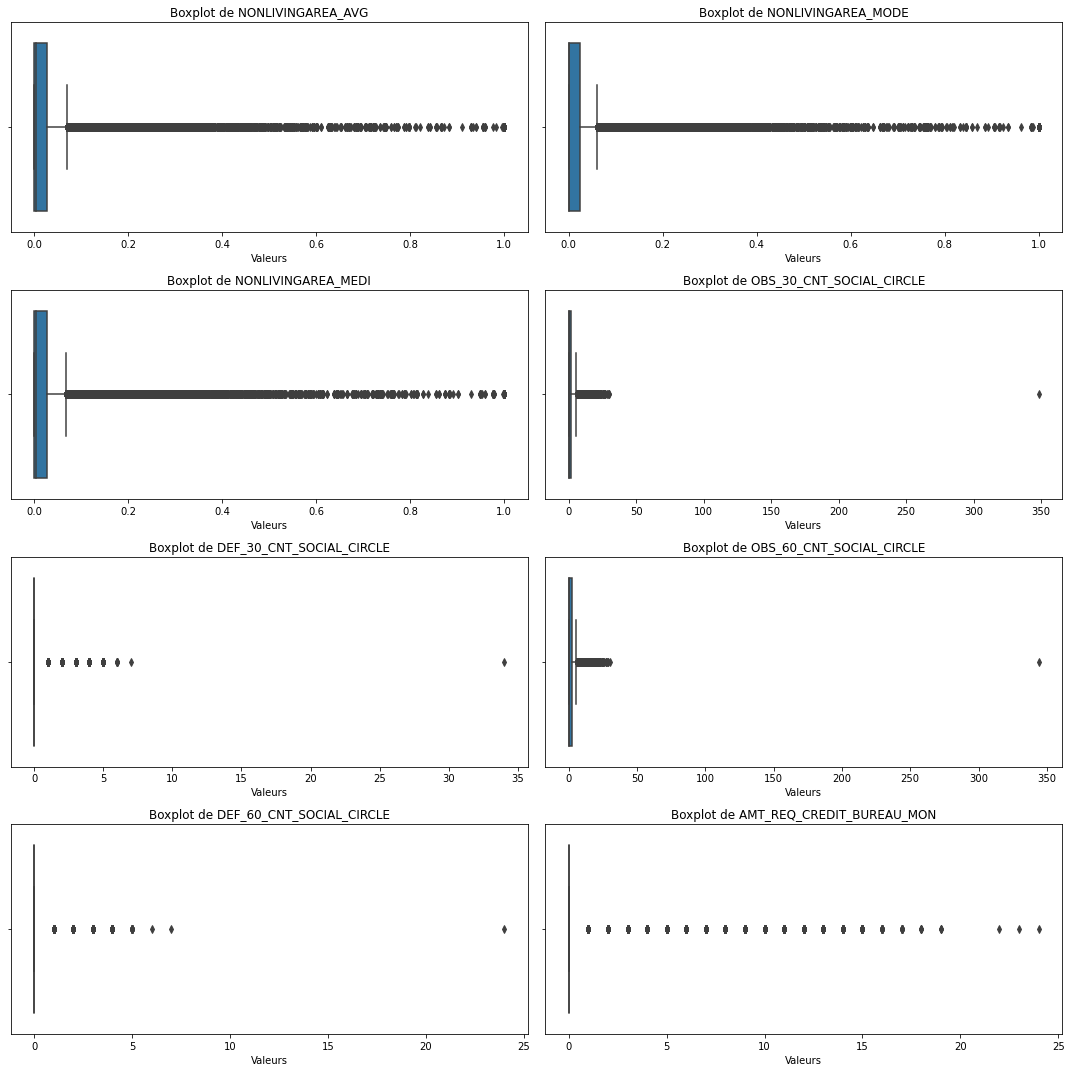

In [34]:
fig, axes = plt.subplots(nrows=len(columns_with_outliers) // 2, ncols=2, figsize=(15, 15))

# Boucler sur les colonnes et les axes
for ax, col in zip(axes.flat, columns_with_outliers):
    sns.boxplot(x=modified_train_int_float[col], ax=ax)
    ax.set_title(f'Boxplot de {col}')
    ax.set_xlabel('Valeurs')

# Ajuster la mise en page
plt.tight_layout()
plt.show()


on consate plusieurs élements sur les variables contenant des valeurs anormales ou extrêmes

1. **AMT_REQ_CREDIT_BUREAU_MON, AMT_REQ_CREDIT_BUREAU_QRT** :
   - **AMT_REQ_CREDIT_BUREAU_MON** (demandes mensuelles de crédit) :
     - Moyenne : 0.26, Médiane : 0, Maximum : 24.
     - La majorité des individus ont peu ou pas de demandes, mais des valeurs élevées, comme 24, suggèrent une activité de crédit excessive ou une anomalie.
   
   - **AMT_REQ_CREDIT_BUREAU_QRT** (demandes trimestrielles de crédit) :
     - Moyenne : 0.27, Médiane : 0, Maximum : 261.
     - Bien que rares, des valeurs extrêmes comme 261 signalent probablement des erreurs ou des comportements atypiques.

2. **OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE** :
   - **OBS_60_CNT_SOCIAL_CIRCLE** (observations sociales sur 60 jours) :
     - Moyenne : 1.41, Médiane : 0, Maximum : 344.
     - Les valeurs élevées comme 344 sont des anomalies, pouvant indiquer un comportement social atypique ou une erreur de saisie.
   
   - **DEF_60_CNT_SOCIAL_CIRCLE** (défauts sociaux sur 60 jours) :
     - Moyenne : 0.14, Médiane : 0, Maximum : 34.
     - Des valeurs élevées comme 34 sont rares et suggèrent des erreurs ou des comportements inhabituels.

3. **OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE** :
   - **OBS_30_CNT_SOCIAL_CIRCLE** (observations sociales sur 30 jours) :
     - Moyenne : 1.41, Médiane : 0, Maximum : 348.
     - Une valeur aussi élevée que 348 est une anomalie marquée.
   
   - **DEF_30_CNT_SOCIAL_CIRCLE** (défauts sociaux sur 30 jours) :
     - Moyenne : 0.10, Médiane : 0, Maximum : 24.
     - Des valeurs comme 24 sont significativement élevées, suggérant des erreurs ou des comportements atypiques.


**Nous allons supprimer ces lignes** afin d'assurer que les données utilisées pour l'analyse sont représentatives et ne biaisent pas les résultats.

In [35]:
# Liste des colonnes d'intérêt
cols = ['OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 
        'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE', 
        'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT']

# Récupérer les lignes avec les valeurs maximales pour chaque colonne
print("Avant suppression : Taille du DataFrame :", modified_train_int_float.shape[0])  # Taille avant suppression

# Identifier les indices des lignes avec les valeurs maximales
indices_to_remove = []

for col in cols:
    max_idx = modified_train_int_float[col].idxmax()  # Récupère l'indice de la valeur maximale
    indices_to_remove.append(max_idx)  # Ajouter l'indice à la liste
    print(f"Pour la colonne '{col}', l'indice avec la valeur maximale est {max_idx}")

# Supprimer les lignes avec ces indices
modified_train_int_float_cleaned = modified_train_int_float.drop(indices_to_remove, errors='ignore')

# Vérifier la taille après suppression
print("Après suppression : Taille du DataFrame :", modified_train_int_float_cleaned.shape[0])  # Taille après suppression



Avant suppression : Taille du DataFrame : 259586
Pour la colonne 'OBS_60_CNT_SOCIAL_CIRCLE', l'indice avec la valeur maximale est 148403
Pour la colonne 'DEF_60_CNT_SOCIAL_CIRCLE', l'indice avec la valeur maximale est 148403
Pour la colonne 'DEF_30_CNT_SOCIAL_CIRCLE', l'indice avec la valeur maximale est 148403
Pour la colonne 'OBS_30_CNT_SOCIAL_CIRCLE', l'indice avec la valeur maximale est 148403
Pour la colonne 'AMT_REQ_CREDIT_BUREAU_MON', l'indice avec la valeur maximale est 12869
Pour la colonne 'AMT_REQ_CREDIT_BUREAU_QRT', l'indice avec la valeur maximale est 239474
Après suppression : Taille du DataFrame : 259583


### 1.2.3 Gestion des Variables Catégorielles

Pour simplifier et rendre les variables catégorielles exploitables dans notre modèle, nous utilisons deux fonctions principales qui abordent différents types de modalités.

#### Étapes principales :
1. **Identification des caractéristiques des modalités** :
   - **Modalités uniques** : Nous identifions les colonnes où toutes les valeurs sont identiques.
   - **Cardinalité élevée** : Détecter les colonnes ayant un grand nombre de catégories distinctes.
   - **Modalités rares** : Identifier les catégories présentes dans très peu d'observations.

2. **Traitement des variables catégorielles** :
   - **Cardinalité élevée** : Utilisation d'un encodage par catégories fréquentes (frequent category encoding) ou regroupement des catégories rares sous un seuil de fréquence minimal.
   - **Modalités rares** : Fusion des catégories peu fréquentes sous une étiquette "Autres" ou suppression selon leur pertinence.
   - **Modalités uniques ou constantes** : Suppression des colonnes ne contenant qu'une seule modalité pour éviter d'ajouter du bruit inutile.


Ces transformations sont uniquement appliquées sur l’ensemble d’entraînement (train). Les mêmes règles sont ensuite appliquées au jeu de test sans ré-entraînement ou recalcul des seuils pour éviter le *data leakage*.



In [36]:
def classifier_colonnes_par_type(file_train):
    # Listes pour stocker les colonnes par type
    colonnes_obj = []  # Colonnes de type 'object'

    # Boucle pour chaque colonne du DataFrame
    for col in file_train.columns:
        # Vérifier le type de chaque colonne
        dtype = str(file_train[col].dtype)  # Récupérer le type sous forme de chaîne

        if dtype == "object":
            colonnes_obj.append(col)  # Ajouter à la liste des colonnes de type 'object'

    # Boucle sur chaque colonne de type 'object'
    for col in colonnes_obj:
        print(f"Colonne : {col}")  # Afficher le nom de la colonne
       # print("Valeurs uniques :", file_train[col].unique())  # Afficher les valeurs uniques
        
        # Obtenir et afficher les types uniques dans la colonne
        types_uniques = file_train[col].apply(type).unique()
        print("Types uniques :", types_uniques)  # Afficher les types uniques dans la colonne
        
        # Vérifier si la colonne a des types uniques ou mixtes
        if len(types_uniques) > 1:
            print("Statut : Cette colonne contient des types mixtes.")
        else:
            print("Statut : Cette colonne a un type unique.")
        
        # Nombre de chaque modalité
        modality_counts = file_train[col].value_counts(dropna=False)
        print("Modalités et leurs occurrences :")
        print(modality_counts)
        print("-----")  # Ligne de séparation pour la lisibilité


### Appel de la fonction
classifier_colonnes_par_type(modified_train_int_float)


Colonne : NAME_CONTRACT_TYPE
Types uniques : [<class 'str'>]
Statut : Cette colonne a un type unique.
Modalités et leurs occurrences :
Cash loans         236875
Revolving loans     22711
Name: NAME_CONTRACT_TYPE, dtype: int64
-----
Colonne : CODE_GENDER
Types uniques : [<class 'str'>]
Statut : Cette colonne a un type unique.
Modalités et leurs occurrences :
F      174980
M       84603
XNA         3
Name: CODE_GENDER, dtype: int64
-----
Colonne : FLAG_OWN_CAR
Types uniques : [<class 'str'>]
Statut : Cette colonne a un type unique.
Modalités et leurs occurrences :
N    172466
Y     87120
Name: FLAG_OWN_CAR, dtype: int64
-----
Colonne : FLAG_OWN_REALTY
Types uniques : [<class 'str'>]
Statut : Cette colonne a un type unique.
Modalités et leurs occurrences :
Y    183427
N     76159
Name: FLAG_OWN_REALTY, dtype: int64
-----
Colonne : CNT_CHILDREN
Types uniques : [<class 'str'>]
Statut : Cette colonne a un type unique.
Modalités et leurs occurrences :
0         184867
1          48286
2      

In [37]:

def regrouper_modalites(df):
    
    df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].replace({
        'Trade: type 1': 'Trade', 'Trade: type 2': 'Trade', 'Trade: type 3': 'Trade', 
        'Trade: type 4': 'Trade', 'Trade: type 5': 'Trade', 'Trade: type 6': 'Trade', 
        'Trade: type 7': 'Trade',

        'Industry: type 1': 'Industry', 'Industry: type 2': 'Industry', 'Industry: type 3': 'Industry',
        'Industry: type 4': 'Industry', 'Industry: type 5': 'Industry', 'Industry: type 6': 'Industry',
        'Industry: type 7': 'Industry', 'Industry: type 8': 'Industry', 'Industry: type 9': 'Industry',
        'Industry: type 10': 'Industry', 'Industry: type 11': 'Industry', 'Industry: type 12': 'Industry',
        'Industry: type 13': 'Industry',

        'Business Entity Type 1': 'Business_Entity', 'Business Entity Type 2': 'Business_Entity',
        'Business Entity Type 3': 'Business_Entity',
    
        'Construction': 'Batiment_gros_petit_oeuvre', 
        'Electricity': 'Batiment_gros_petit_oeuvre',  # Ajout de la virgule manquante

        'Government': 'Public_Services', 'Police': 'Public_Services', 'Postal': 'Public_Services',
        'Security Ministries': 'Public_Services',

        'School': 'Education_Services', 'Kindergarten': 'Education_Services', 'University': 'Education_Services',

        'Transport: type 1': 'Transport', 'Transport: type 2': 'Transport', 'Transport: type 3': 'Transport', 
        'Transport: type 4': 'Transport',

        'Bank': 'Finance', 'Insurance': 'Finance',

        'Services': 'Services', 'Restaurant': 'Services', 'Hotel': 'Services', 'Cleaning': 'Services',

        'Realtor': 'Real_Estate', 'Housing': 'Real_Estate',

        'Telecom': 'Other', 'Emergency': 'Other', 'Advertising': 'Other', 'Culture': 'Other',      
        'Mobile': 'Other', 'Legal Services': 'Other', 'Religion': 'Other', 'Military': 'Other',

        'XNA': np.nan  # Remplacer 'XNA' par NaN
    })

    # Remplacer les modalités dans d'autres colonnes
    df['NAME_TYPE_SUITE'] = df['NAME_TYPE_SUITE'].replace(['Other_A', 'Other_B', 'Group of people'], 'Other')

    df['NAME_EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].replace(
        ['Incomplete higher', 'Lower secondary', 'Academic degree'], 'Other')

    df['NAME_HOUSING_TYPE'] = df['NAME_HOUSING_TYPE'].replace(
        ['Rented apartment', 'Office apartment', 'Co-op apartment'], 'Other housing types')

    df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].replace(
        ['Private service staff', 'Low-skill Laborers', 'Waiters/barmen staff', 'Secretaries', 
         'Realty agents', 'HR staff', 'IT staff'], 'Other_specialized')

    df['WALLSMATERIAL_MODE'] = df['WALLSMATERIAL_MODE'].replace({'Others': np.nan})

    return df


def supprimer_valeur(df):
    # Supprimer les valeurs manquantes de NAME_TYPE_SUITE
    df = df.dropna(subset=['NAME_TYPE_SUITE'])

    # Filtrer les lignes avec certaines modalités de NAME_INCOME_TYPE
    df = df[~df['NAME_INCOME_TYPE'].isin(['Unemployed', 'Student', 'Businessman', 'Maternity leave'])]

    # Exclure les lignes avec CODE_GENDER 'XNA' et NAME_FAMILY_STATUS 'Unknown'
    df = df[df['CODE_GENDER'] != 'XNA']
    df = df[df['NAME_FAMILY_STATUS'] != 'Unknown']

    return df



##### Modification pour Train et test

In [38]:
# Modification pour Train
train_propre = regrouper_modalites(modified_train_int_float)
train_propre = supprimer_valeur(modified_train_int_float)

# Modification pour Train
test_propre = regrouper_modalites(modified_test_int_float)
test_propre = supprimer_valeur(modified_test_int_float)


##### Vérification des changements 

In [39]:
## Appel de la fonction pour vérifier
classifier_colonnes_par_type(train_propre)

Colonne : NAME_CONTRACT_TYPE
Types uniques : [<class 'str'>]
Statut : Cette colonne a un type unique.
Modalités et leurs occurrences :
Cash loans         236015
Revolving loans     22481
Name: NAME_CONTRACT_TYPE, dtype: int64
-----
Colonne : CODE_GENDER
Types uniques : [<class 'str'>]
Statut : Cette colonne a un type unique.
Modalités et leurs occurrences :
F    174304
M     84192
Name: CODE_GENDER, dtype: int64
-----
Colonne : FLAG_OWN_CAR
Types uniques : [<class 'str'>]
Statut : Cette colonne a un type unique.
Modalités et leurs occurrences :
N    171725
Y     86771
Name: FLAG_OWN_CAR, dtype: int64
-----
Colonne : FLAG_OWN_REALTY
Types uniques : [<class 'str'>]
Statut : Cette colonne a un type unique.
Modalités et leurs occurrences :
Y    183016
N     75480
Name: FLAG_OWN_REALTY, dtype: int64
-----
Colonne : CNT_CHILDREN
Types uniques : [<class 'str'>]
Statut : Cette colonne a un type unique.
Modalités et leurs occurrences :
0         184103
1          48078
2          22511
3       

### 1.2.4 Gestion des valeurs manquantes

1. **Identification des valeurs manquantes** :
   - Analyse de la proportion de données manquantes pour chaque ligne, variable.

2. **Traitement des valeurs manquantes** : Une imputation univariée a été réalisée selon le type de variable : 

   - **Suppression** : Les variables contenant plus de 50 % de valeurs manquantes sont supprimées.
   - **Variables quantitatives** : Imputation par la médiane pour limiter l'impact des valeurs extrêmes.
   - **Variables binaires** : Imputation par la valeur la plus fréquente (*mode*).
   - **Variables qualitatives** : Imputation par la modalité la plus fréquente afin de préserver la cohérence des catégories.

3. **Application cohérente aux données de test** :
   - Les données de test sont imputées en utilisant les mêmes méthodes que celles appliquées aux données d’entraînement.
   - Les statistiques utilisées (médiane, mode) sont calculées uniquement sur l’ensemble d’entraînement pour éviter tout `data leakage.`


In [40]:
def report_missing_data(df, dataset_name="Dataset"):
  
    # Nombre total de lignes
    total_rows = len(df)
    
    # Nombre de lignes complètes (sans valeurs manquantes)
    complete_rows = df.dropna().shape[0]
    
    # Nombre de lignes manquantes
    missing_rows = total_rows - complete_rows
    
    # Calculer le pourcentage de lignes manquantes
    percentage_missing = (missing_rows / total_rows) * 100
    
    # Calculer le nombre de colonnes avec plus de 50% de valeurs manquantes
    columns_above_50_missing = len(df.isna().mean()[df.isna().mean() > 0.50])
    
    # Calculer le nombre de colonnes sans aucune valeur manquante
    columns_no_missing = len(df.isna().mean()[df.isna().mean() == 0])
    
    # Afficher les résultats pour le dataset spécifié
    print(f"--- Rapport de données manquantes pour {dataset_name} ---")
    print(f"Total de lignes : {total_rows}")
    print(f"Lignes complètes : {complete_rows}")
    print(f"Lignes manquantes : {missing_rows}")
    print(f"Pourcentage de lignes manquantes : {percentage_missing:.2f}%")
    print(f"Nombre de colonnes avec plus de 50% de valeurs manquantes : {columns_above_50_missing}")
    print(f"Nombre de colonnes sans valeurs manquantes : {columns_no_missing}")
    print("\n")  # Ligne vide pour séparer les rapports



In [41]:
# Fonction pour afficher les colonnes avec des valeurs manquantes pour chaque type
def missing_values_by_type(data, columns, dtype_name):
    missing_info = {}
    for col in columns:
        missing_count = data[col].isna().sum()
        if missing_count > 0:
            missing_info[col] = (missing_count, (missing_count / len(data)) * 100)
    
    # Afficher le rapport des colonnes avec des valeurs manquantes pour le type
    if missing_info:
        print(f"--- Variables de type {dtype_name} avec valeurs manquantes ---")
        for col, (count, pct) in missing_info.items():
            print(f"  - {col} : {count} valeurs manquantes ({pct:.2f}%)")
    else:
        print(f"Aucune variable de type {dtype_name} ne contient de valeurs manquantes.")
        
    # Saut de ligne pour séparer les rapports de chaque type
    print()

##### Vérification Géneral des données manquantes

In [42]:
# Appel de la fonction
report_missing_data(train_propre, dataset_name="Train")
report_missing_data(test_propre, dataset_name="Test")

--- Rapport de données manquantes pour Train ---
Total de lignes : 258496
Lignes complètes : 6765
Lignes manquantes : 251731
Pourcentage de lignes manquantes : 97.38%
Nombre de colonnes avec plus de 50% de valeurs manquantes : 47
Nombre de colonnes sans valeurs manquantes : 57


--- Rapport de données manquantes pour Test ---
Total de lignes : 40241
Lignes complètes : 1384
Lignes manquantes : 38857
Pourcentage de lignes manquantes : 96.56%
Nombre de colonnes avec plus de 50% de valeurs manquantes : 33
Nombre de colonnes sans valeurs manquantes : 56




**On supprime les variables a plus de 50% valeurs manquantes**

In [43]:
# Sélectionner les colonnes avec plus de 50 % de valeurs manquantes dans chaque DataFrame
l_var_nan_train = train_propre.columns[train_propre.isna().mean() > 0.5].tolist()
l_var_nan_test = test_propre.columns[test_propre.isna().mean() > 0.5].tolist()

# Supprimer les colonnes en fonction train
train_cleaned = train_propre.drop(columns=l_var_nan_train, errors='ignore')
test_cleaned = test_propre.drop(columns=l_var_nan_train, errors='ignore')

In [44]:
print(train_cleaned.shape)
print(test_cleaned.shape)

(258496, 75)
(40241, 74)


**On applique l'imputation**

In [45]:
# Sélection des colonnes en fonction du type de données
obj_cols = train_cleaned.select_dtypes(include=['object']).columns
int_cols = train_cleaned.select_dtypes(include=['int64']).columns
float_cols = train_cleaned.select_dtypes(include=['float64']).columns

# Imputation des valeurs manquantes pour les colonnes de type float
for col in float_cols:
    if train_cleaned[col].isna().sum() > 0: # Vérifie si la colonne contient des valeurs manquantes
        median_value = train_cleaned[col].median()
        # Remplace les valeurs manquantes dans le jeu d'entraînement par la médiane
        train_cleaned[col].fillna(median_value, inplace=True) 
        # Remplace les valeurs manquantes dans le jeu de test par la médiane de l'entrainement
        test_cleaned[col].fillna(median_value, inplace=True)

        
# Imputer les variables qualitatives (object) et binaires par le mode
for col in obj_cols:
    if train_cleaned[col].isna().sum() > 0:
        mode_value = train_cleaned[col].mode()[0]
        train_cleaned[col].fillna(mode_value, inplace=True)
        test_cleaned[col].fillna(mode_value, inplace=True)


              
# vérification
print(train_cleaned.isna().mean()[train_cleaned.isna().mean() > 0])
print(test_cleaned.isna().mean()[train_cleaned.isna().mean() > 0])

Series([], dtype: float64)
Series([], dtype: float64)


## 1.3 Vérification finale du **Data Leakage**

Le **data leakage** peut gravement fausser les performances d’un modèle en introduisant des informations que le modèle n’aurait pas en conditions réelles. Deux types principaux de fuites sont identifiés :

1. **Contamination des ensembles d’entraînement et de test** : Cela survient lorsque les données de validation ou de test sont utilisées dans l'entraînement à cause d'un mauvais fractionnement ou prétraitement.  
   `Ce risque a été anticipé grâce à un prétraitement strict et une validation croisée appropriée, comme détaillé ultérieurement.`

2. **Fuite cible** : Cette fuite implique l'inclusion de données non disponibles lors de la prédiction réelle, faussant ainsi les résultats. Voici les méthodes appliquées pour éviter ce risque :

   - **Inclusion d’informations futures** :  Vérification que les colonnes temporelles ne contiennent que des données antérieures ou contemporaines à l’événement à prédire.

   - **Sélection de fonctionnalités inappropriées** : Une attention particulière a été portée aux relations entre les variables explicatives et la cible en fonction du type de données. Les variables présentant une forte corrélation sans lien causal réel ont été écartées pour éviter toute fuite indirecte.

**Relations entre les variables explicatives qualitatives et la variable cible**

- Effectue le test du Chi-Carré pour les variables catégorielles par rapport à une colonne cible.
- Calcule également l'indice de Cramér's V pour évaluer la force de l'association.
- Graphique

In [46]:
# Fonction pour calculer le test du Chi-Carré et Cramér's V

def build_chi2_cramer_table(dataframe, target_col, obj_cols):
  
     # Initialise un dictionnaire pour stocker les résultats
    chi2_results = {}

    # Tester chaque colonne catégorielle avec la variable cible
    for col in obj_cols:
        # Ignorer la colonne cible
        if col == target_col:
            continue

        contingency_table = pd.crosstab(dataframe[col], dataframe[target_col])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        # Calculer l'indice de Cramér's V
        n = contingency_table.sum().sum()  # Taille de l'échantillon
        min_dim = min(contingency_table.shape) - 1
        cramer_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0
        
        # Vérifier si les valeurs attendues sont supérieures à 5
        expected_check = expected > 5
        expected_valid = expected_check.sum() / expected.size > 0.8
        
        # Stocke les résultats avec arrondi
        chi2_results[col] = {
            'chi2_stat': round(chi2, 5),
            'p_value': round(p, 5),
            'cramer_v': round(cramer_v, 5),
            'expected_valid': expected_valid
        }

    return pd.DataFrame(chi2_results).T


In [47]:
# Sélectionne les meilleures variables selon Cramér's V, avec p-value < 0.05.

def top_features_by_cramer(chi2_cramer_df, top_n=4):
   
    filtered_df = chi2_cramer_df[chi2_cramer_df['p_value'] < 0.05]
    top_features = filtered_df.sort_values(by='cramer_v', ascending=False).head(top_n)
    
    return top_features


###### Appel de la fonction pour les colonnes types 'obj'

In [48]:
chi2_results_df_object = build_chi2_cramer_table(train_cleaned, 'TARGET', obj_cols)
top_features = top_features_by_cramer(chi2_results_df_object, top_n=4)
print("\nLes 4 meilleures variables selon Cramér's V pour les types 'object':")
top_features



Les 4 meilleures variables selon Cramér's V pour les types 'object':


,chi2_stat,p_value,cramer_v,expected_valid
NAME_INCOME_TYPE,1065.36985,0.0,0.0642,True
OCCUPATION_TYPE,838.45994,0.0,0.05695,True
CODE_GENDER,834.70524,0.0,0.05683,True
NAME_EDUCATION_TYPE,735.03771,0.0,0.05332,True


###### Appel de la fonction pour les colonnes types 'int64'

In [49]:
# Exemple pour les colonnes 'int64'
chi2_results_df_int64 = build_chi2_cramer_table(train_cleaned, 'TARGET', int_cols)
top_features = top_features_by_cramer(chi2_results_df_int64, top_n=4)
print("\nLes 4 meilleures variables selon Cramér's V pour les types 'int64':")
top_features


Les 4 meilleures variables selon Cramér's V pour les types 'int64':


,chi2_stat,p_value,cramer_v,expected_valid
AGE,1721.60228,0.0,0.08161,True
REGION_RATING_CLIENT_W_CITY,918.91616,0.0,0.05962,True
REGION_RATING_CLIENT,855.62266,0.0,0.05753,True
DAYS_LAST_PHONE_CHANGE_YEARS,819.92403,0.0,0.05632,True


**Relations entre les variables explicatives quantitatives et la variable cible**
- On va calculer la corrélation de Spearman 

In [50]:
# Liste pour stocker les résultats
results_list = []

# Calculer la corrélation de Spearman pour chaque variable numérique
for col in float_cols:
    corr, p_value = spearmanr(train_cleaned["TARGET"], train_cleaned[col])
    results_list.append({
        'variable': col,
        'spearman_correlation': round(corr, 4),  # Arrondi à 4 chiffres après la virgule
        'spearman_p_value': round(p_value, 4)    # Arrondi à 4 chiffres après la virgule
    })

# Convertir les résultats en DataFrame pour affichage
results_df = pd.DataFrame(results_list)

# Filtrer les p-values < 0.05 et trier par la corrélation absolue
filtered_df = results_df[results_df['spearman_p_value'] < 0.05]
top_features = filtered_df.reindex(
    filtered_df['spearman_correlation'].abs().sort_values(ascending=False).index
).head(4)

# Affichage des meilleurs résultats
print("Les 4 meilleures variables selon la corrélation de Spearman :")
top_features


Les 4 meilleures variables selon la corrélation de Spearman :


,variable,spearman_correlation,spearman_p_value
6,EXT_SOURCE_2,-0.1435,0.0
7,EXT_SOURCE_3,-0.1390,0.0
19,EMPLOYMENT_DURATION,-0.0740,0.0
10,DEF_30_CNT_SOCIAL_CIRCLE,0.0334,0.0


## 1.4 Analyse de la distribution TARGET

In [51]:
train_cleaned["TARGET"].value_counts(normalize=True)

0    0.921995
1    0.078005
Name: TARGET, dtype: float64

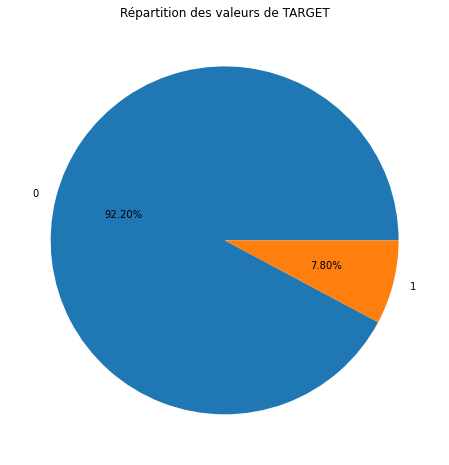

In [52]:
# Ajuster la taille de la figure
plt.figure(figsize=(8, 8))  # Taille plus grande, ajuste (largeur, hauteur) comme tu veux

# Créer le graphique en camembert
plt.pie(
    train_cleaned["TARGET"].value_counts(normalize=True),
    labels=train_cleaned["TARGET"].value_counts(normalize=True).index,
    autopct='%.2f%%'
)

# Ajouter un titre
plt.title("Répartition des valeurs de TARGET")

# Afficher le graphique
plt.show()


## 1.5 Sauvegarde des prétraitements

### 1.5.1 Finalisation de la gestion des variables catégorielles

Convertir les variables catégorielles en variables numériques adaptées aux modèles de machine learning. Et on assure la cohenrence des des transformations effectuées sur l'ensemble d'entraînement doivent être identiques sur l'ensemble de testpour éviter fuite de donnée.

##### Méthode
Utilisation de `pd.get_dummies()` avec `drop_first=True` :  
- Évite la **multicolinéarité** (redondance entre colonnes).  
- Réduit la **dimensionnalité** des données.  
- Assure que l'ensemble de test utilise les mêmes colonnes que l'ensemble d'entraînement, en ajoutant des colonnes manquantes avec des valeurs par défaut (fill_value=0) si nécessaire. 

In [53]:
from sklearn.preprocessing import  OneHotEncoder

In [54]:
# On spécifie les colonnes 
obj_cols_train = train_cleaned.select_dtypes(include=['object']).columns
obj_cols_test = test_cleaned.select_dtypes(include=['object']).columns

###################################################
# 1. Encodage One-Hot pour les colonnes catégorielles
#################################################

train_final = pd.get_dummies(train_cleaned, columns=obj_cols_train, drop_first=True)
test_final = pd.get_dummies(test_cleaned, columns=obj_cols_test, drop_first=True)

#############################################
## 2. Assurer la cohérence entre train et test
#############################################

# Colonnes dans test mais pas dans train
extra_columns = set(test_final.columns) - set(train_final.columns)
print("Colonnes supplémentaires dans test :", extra_columns)

# Colonnes dans train mais absentes dans test
missing_columns = set(train_final.columns) - set(test_final.columns)
print("Colonnes manquantes dans test :", missing_columns)

print(train_final.shape)
print(test_final.shape)


Colonnes supplémentaires dans test : set()
Colonnes manquantes dans test : {'TARGET'}
(258496, 118)
(40241, 117)


## 1.5.2 Vérification et nettoyage des noms des colonnes

**On vérifie que les noms des colonnes ne sont pas problematiques sinon on corrige**

In [55]:
# Fonction pour détecter les caractères spéciaux

def has_special_characters(column_name):
    return bool(re.search(r'[^a-zA-Z0-9_]', column_name))

# Appliquer la fonction pour trouver des colonnes problématiques
problematic_columns = [col for col in train_final.columns if has_special_characters(col)]
print("Colonnes problématiques : ", problematic_columns)

Colonnes problématiques :  ['NAME_CONTRACT_TYPE_Revolving loans', 'NAME_TYPE_SUITE_Spouse, partner', 'NAME_INCOME_TYPE_State servant', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_FAMILY_STATUS_Single / not married', 'NAME_HOUSING_TYPE_Municipal apartment', 'NAME_HOUSING_TYPE_Other housing types', 'NAME_HOUSING_TYPE_With parents', 'OCCUPATION_TYPE_Cleaning staff', 'OCCUPATION_TYPE_Cooking staff', 'OCCUPATION_TYPE_Core staff', 'OCCUPATION_TYPE_High skill tech staff', 'OCCUPATION_TYPE_Medicine staff', 'OCCUPATION_TYPE_Sales staff', 'OCCUPATION_TYPE_Security staff', 'ORGANIZATION_TYPE_Self-employed']


**Correction de ces colonnes problématiques sur train et test**


In [56]:
def rename_columns(col):
    # Remplace les caractères accentués par leurs équivalents non accentués
    col = unidecode(col)
    # Remplace tout caractère qui n'est pas alphanumérique ou underscore par un underscore
    col = re.sub(r'[^a-zA-Z0-9_]', '_', col)
    # Remplace les underscores multiples par un seul
    col = re.sub(r'_+', '_', col)
    # Enlève les underscores au début et à la fin de la chaîne
    return col.strip('_')


# Appliquer le renommage à toutes les colonnes de train_final
train_final.columns = [rename_columns(col) for col in train_final.columns]

# Appliquer le renommage à toutes les colonnes de test_final
test_final.columns = [rename_columns(col) for col in test_final.columns]


In [57]:
# vérification

# Appliquer la fonction pour trouver des colonnes problématiques
problematic_columns = [col for col in train_final.columns if has_special_characters(col)]
print("Colonnes problématiques Train : ", problematic_columns)

# Appliquer la fonction pour trouver des colonnes problématiques
problematic_columns = [col for col in test_final.columns if has_special_characters(col)]
print("Colonnes problématiques Test : ", problematic_columns)

Colonnes problématiques Train :  []
Colonnes problématiques Test :  []


### 1.4.3 Sauvegarde des prétraitements

In [58]:
# Sauvegarder un DataFrame en CSV
train_final.to_csv('Final_train.csv', index=False)  # 'index=False' pour ne pas sauvegarder l'index du DataFrame
test_final.to_csv('Final_test.csv', index=False)

#### Vérification

In [59]:
F_train = pd.read_csv('Final_train.csv')
F_test = pd.read_csv('Final_test.csv')


# Récupérer le nombre de lignes et de colonnes
print(F_train.shape)
print(F_test.shape)

(258496, 118)
(40241, 117)


In [60]:
F_train.head(2)

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,...,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Public_Services,ORGANIZATION_TYPE_Real_Estate,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Self_employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Trade,ORGANIZATION_TYPE_Transport,EMERGENCYSTATE_MODE_Yes
0,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,1,1,1,...,0,0,1,0,0,0,0,0,0,0


In [61]:
F_test.head(2)

,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,...,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Public_Services,ORGANIZATION_TYPE_Real_Estate,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Self_employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Trade,ORGANIZATION_TYPE_Transport,EMERGENCYSTATE_MODE_Yes
0,100001,135000.0,568800.0,20560.5,450000.0,0.018850,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,100005,99000.0,222768.0,17370.0,180000.0,0.035792,1,1,0,1,...,0,0,0,0,0,1,0,0,0,0
